## Disease prediction
#### EDA
Datasetet *cardio_train.csv* som innehåller data om ca 70 000 personer undersöktes, där syftet var att förutspå förekomsten av hjärt-kärlsjukdomar utifrån givna data. Detta gjordes med hjälp av flera olika maskininlärningsmodeller, där den bästa valdes ut och testkördes.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("cardio_train.csv", sep=";")
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


De prediktorer som låg till grund för att förutspå förekomsten av hjärt-kärlsjukdom var ålder, kön, längd, vikt, blodtryck (systoliskt och diastoliskt), kolesterolnivå, glukosnivå, samt ja/nej-variabler på rökning, alkoholintag och träning.

Det konstaterades att min- och max-värden hos vissa av prediktorerna var orimliga, och att en del poster behövde rensas ut. Kvartilavstånd och medianer såg normala ut. Av de 70 000 personerna hade nästan exakt hälften testat positivt för hjärt-kärlsjukdom. 

In [17]:
print(f"Har inte hjärt-kärlsjukdom: {df["cardio"].value_counts()[0]}\nHar hjärt-kärlsjukdom: {df["cardio"].value_counts()[1]}")

Har inte hjärt-kärlsjukdom: 35021
Har hjärt-kärlsjukdom: 34979


Kolesterolvärdena undersöktes för patienterna. Värdena redovisades med hjälp av en kategorisk variabel, där 1=*normal*, 2=*above normal*, och 3=*well above normal*. Resultatet redovisas i diagrammet nedan. Det konstaterades att ca 3/4 av alla i den gruppen hade normalt kolesterolvärde, medan kategori 2 och 3 utgjorde vardera ca 1/8. 

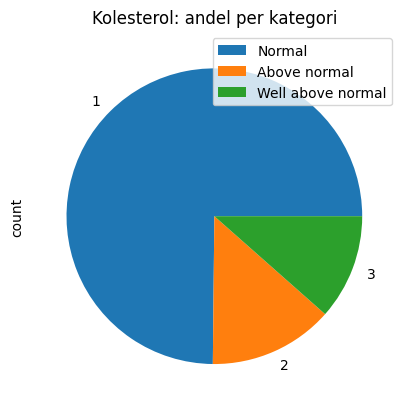

In [4]:
df["cholesterol"].value_counts().plot(kind="pie")
plt.title("Kolesterol: andel per kategori")
plt.legend(["Normal", "Above normal", "Well above normal"]);

Åldrarna i underökningsgruppen var angiven i dagar. Ett histogram med *binwidth*=100 gav en oväntad fördelning av åldrarna, med toppar och dalar ungefär i 2-årsintervall. En närmare analys i form av ett histogram där alla åldrar beräknats modulo 730 (antal dagar på 2 år), gav vid handen att många var födda i början och slutet av varje 2-årsperiod, men nästan ingen i mitten. Någon förklaring till denna fördelning fanns ej, men det fanns anledning att misstänka att det var ett systematiskt fel av något slag.

Omräknat till år låg åldrarna mellan 39 och 62 år, med några få undantag vars poster rensades bort på grund av deras orimlighet. (Åldrarna i sig var inte orimliga, men fördelningen av de övriga åldrarna visade att undersökningen hade en tydlig nedre gräns kring 14 000 dagar. De enstaka lägre värdena antogs vara felregistreringar.)

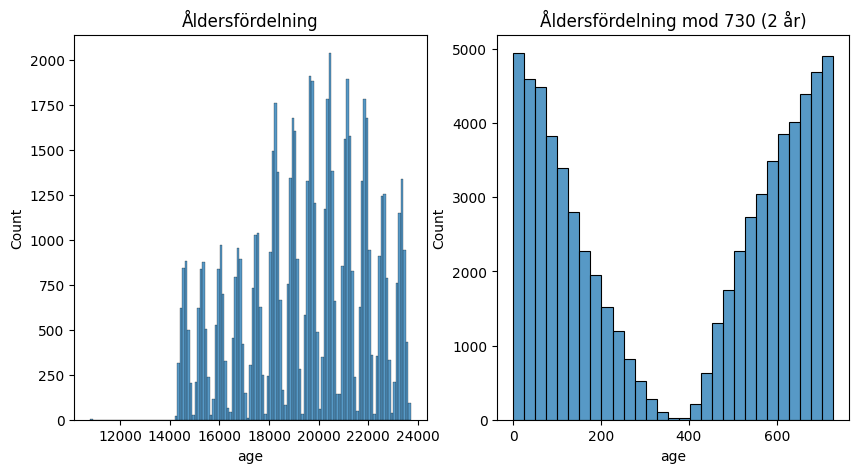

In [5]:
fig, ax=plt.subplots(1, 2, figsize=(10,5))
sns.histplot(df["age"], binwidth=100, ax=ax[0]).set_title("Åldersfördelning")
sns.histplot(df["age"] % 730, ax=ax[1]).set_title("Åldersfördelning mod 730 (2 år)");

Rökning skulle kunna vara en viktig faktor för hjärt-kärlsjukdom. Andelen rökare undersöktes, och det befanns vara ca 9% av undersökningsgruppen som rökte medan övriga 91% var icke-rökare.

Andel icke-rökare: 0.912
Andel rökare: 0.088


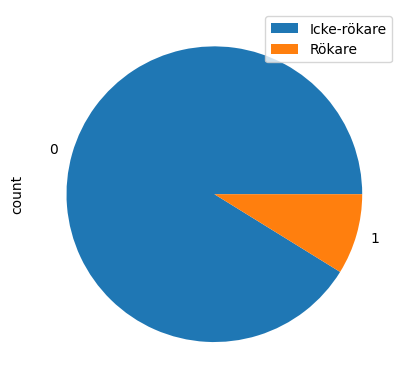

In [21]:
print(f"Andel icke-rökare: {df["smoke"].value_counts(normalize=True)[0]:.3f}\nAndel rökare: {df["smoke"].value_counts(normalize=True)[1]:.3f}")
df["smoke"].value_counts().plot(kind="pie")
plt.legend(["Icke-rökare", "Rökare"]);

Fördelningen av kroppsvikter i gruppen undersöktes, och redovisades i ett histogram med 5kg-intervall och en boxplot. Fördelningen liknade en normalfördelning med medelvärde kring 75 kg, men med viss överrepresentation av överviktiga, vilket kanske ej var förvånande med tanke på att det var hjärtsjukdomar som undersöktes. Många utliggare syntes i boxplotten, vilket var helt i sin ordning i ett dataset av det här omfånget.

Ett fåtal personer hade dock en registrerad kroppsvikt under 25 kg. De antogs vara felregistreringar, och rensades bort vid ett senare tillfälle. En post med kroppsvikt kring 200 kg behölls dock tills vidare.

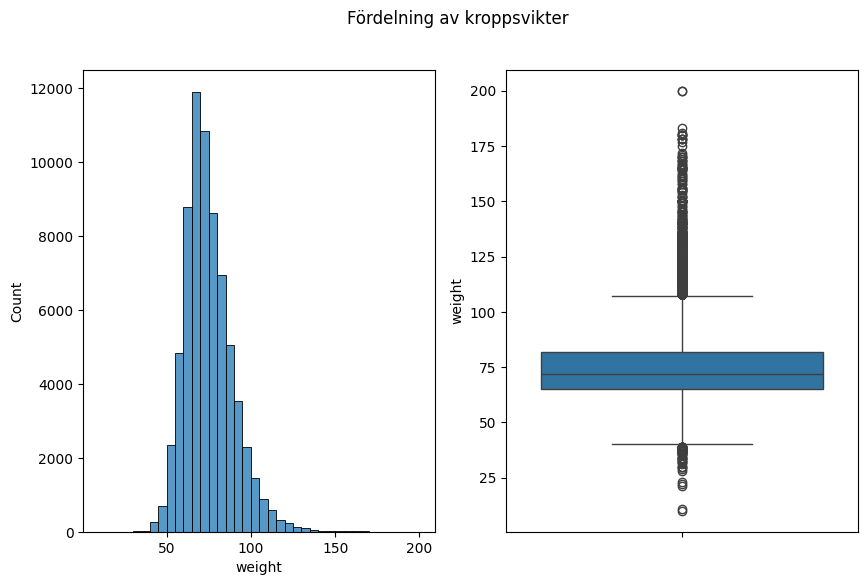

In [22]:
fig, ax=plt.subplots(1, 2, figsize=(10,6))
sns.histplot(df["weight"], binwidth=5, ax=ax[0])
sns.boxplot(df["weight"], ax=ax[1])
fig.suptitle("Fördelning av kroppsvikter");


Även fördelningen av kroppslängder undersöktes. Denna fördelning såg också vid en första anblick normal ut, något som påminde om en normalfördelning med medelvärde kring 165 cm. Det faktum att x-skalan sträckte sig ända från 50 till 250 cm gjorde dock att vissa värden behövde undersökas närmare. Med hjälp av boxplotten konstaterades att det fanns ett förhållandevis stort antal kroppslängder under 100 cm. Framför allt syntes en stor grupp mellan ca 55 och 80 cm (och därefter ett litet "hopp" till de mer normala utliggarna).

Det verkade högst osannolikt att det fanns så många kortväxta personer i den undersökta gruppen, och det antogs att en möjlig förklaring var att dessa personers kroppslängder råkat bli angivna i tum istället för cm. En multiplikation med 2.54 (antalet cm på en tum) gav ett intervall på ca 140-200 cm, vilket torde vara mer normalt. På grund av den stora osäkerheten rensades dock dessa poster ut i ett senare skede. Även dataposten med en kroppslängd på 250 cm rensades bort.


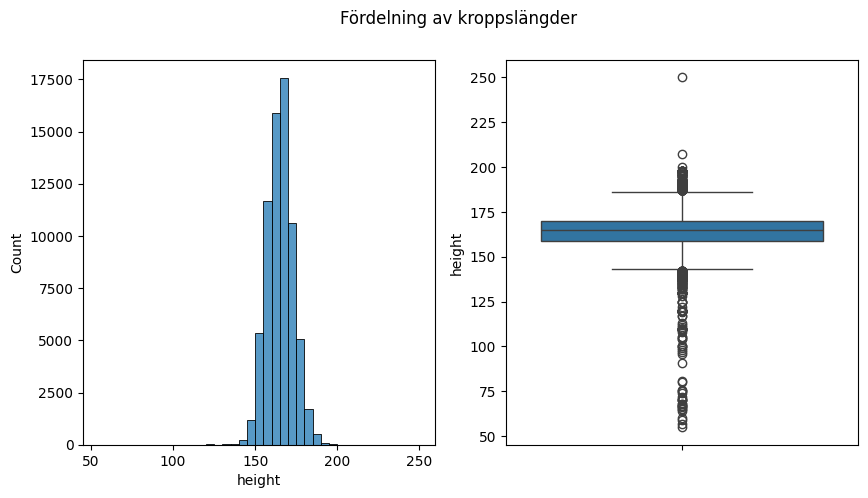

In [9]:
fig, ax=plt.subplots(1, 2, figsize=(10,5))
sns.histplot(df["height"], binwidth=5, ax=ax[0])
sns.boxplot(df["height"], ax=ax[1])
fig.suptitle("Fördelning av kroppslängder");


Slutligen undersökes om det fanns någon skillnad mellan förekomst av hjärt-kärlsjukdom hos män respektive kvinnor bland personerna i datasetet. Det visade sig att något färre än hälften av kvinnorna, och något fler än hälften av männen hade hjärt-kärlsjukdom, men andelarna låg i båda fallen mycket nära 50%.

Det bör dock påpekas att betydligt fler kvinnor än män ingick i undersökningen, så bland de patienter som hade hjärt-kärlsjukdom var 65 % kvinnor (22 616 av 34 979). En möjlig förklaring till detta antogs vara att man utöver de sjuka personerna haft en referensgrupp bestående av ungefär lika många friska kvinnor som de sjukas antal, och samma med männen, men där kvinnor alltså varit i klar majoritet både bland de sjuka och friska.



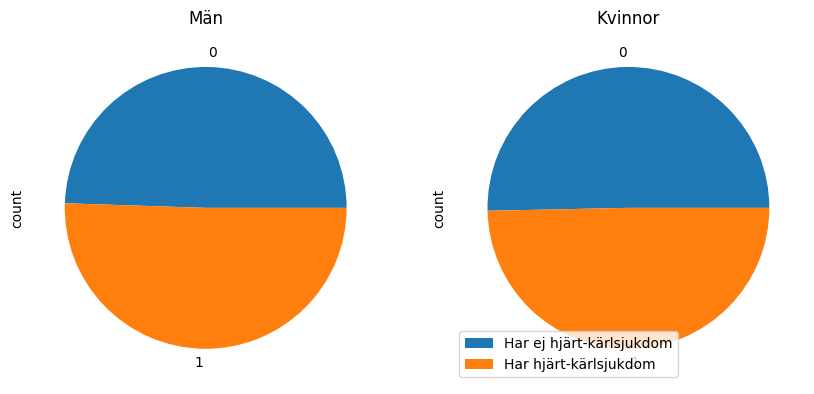

In [10]:
df_male=df[df["gender"]==2]
df_female=df[df["gender"]==1]

plt.figure(figsize=(10,9))
plt.subplot(1,2,1)
df_male["cardio"].value_counts().iloc[::-1].plot(kind="pie")
plt.title("Män")
plt.subplot(1,2,2)
df_female["cardio"].value_counts().plot(kind="pie")
plt.title("Kvinnor")
plt.legend(["Har ej hjärt-kärlsjukdom", "Har hjärt-kärlsjukdom"]);

In [25]:
print(f"Män:\nMed hjärt-kärlsjukdom: {df_male["cardio"].value_counts()[1]}\nUtan hjärt-kärlsjukdom: {df_male["cardio"].value_counts()[0]}")
print(f"Kvinnor:\nMed hjärt-kärlsjukdom: {df_female["cardio"].value_counts()[1]}\nUtan hjärt-kärlsjukdom: {df_female["cardio"].value_counts()[0]}")

Män:
Med hjärt-kärlsjukdom: 12363
Utan hjärt-kärlsjukdom: 12107
Kvinnor:
Med hjärt-kärlsjukdom: 22616
Utan hjärt-kärlsjukdom: 22914
